### Read transformed data

In [ ]:
import pandas as pd

df_clean = pd.read_csv("atp_transformed/2000-2024 players_3.csv")

C:\Users\jesse\AppData\Local\Temp\ipykernel_15496\354828336.py:3: DtypeWarning: Columns (15,16,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv("atp_transformed/2000-2024 players_2.csv")


In [3]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177422 entries, 0 to 1177421
Columns: 132 entries, tourney_id to player_hand_missing
dtypes: float64(96), int64(16), object(20)
memory usage: 1.2+ GB


In [4]:
unique_players = df_clean['player_id'].nunique()
print(f"Number of unique players: {unique_players}")

Number of unique players: 9941


In [5]:
# Convert tourney_date to datetime
df_clean['tourney_date_datetime'] = pd.to_datetime(df_clean['tourney_date'])

# Extract year
df_clean['year'] = df_clean['tourney_date_datetime'].dt.year

In [6]:
player_year_rank = (
    df_clean.groupby(['player_id', 'year'])['player_rank']
      .mean().round(2)
      .reset_index()
      .rename(columns={'player_rank': 'avg_rank_year'})
)

In [7]:
# Compute each player's average rank from 2018–2023
avg_rank_fixed_5yrs = (
    df_clean.query("2018 <= year <= 2023")
    .groupby('player_id')['player_rank']
    .mean().round(2)
    .reset_index()
    .rename(columns={'player_rank': 'avg_rank_prev_5yrs'})
)

# Merge back to assign this fixed average to all years
df_clean = df_clean.merge(avg_rank_fixed_5yrs, on='player_id', how='left')

In [8]:
player_year_rank['rank_change'] = (
    player_year_rank
    .sort_values(['player_id', 'year'])
    .groupby('player_id')['avg_rank_year']
    .diff(periods=-1)  # or diff(periods=1), depending on direction you prefer
                       # A negative change means improvement (rank number decreased, better ranking).
                       # A positive change means decline (rank number increased).
)


In [9]:
df_clean = df_clean.merge(player_year_rank, on=['player_id', 'year'], how='left')

In [10]:
years_with_nan = df_clean[df_clean['rank_change'].isna()]['year'].unique()
print("Years with rank_change NaN:", years_with_nan)


Years with rank_change NaN: [1975 1974 1977 1973 1978 1979 1981 1984 1982 1980 1985 1983 1989 2024
 1986 1987 2000 1993 1991 1994 2004 1996 1992 1995 2002 2001 1997 2011
 2009 2007 2005 2003 1998 2006 2010 2008 2016 2023 2012 2014 2015 2013
 2018 2017 1999 2021 2022 2019 2020]


In [11]:
# Group by year and check if all rank_change are NaN
years_only_nan = df_clean.groupby('year')['rank_change'].apply(lambda x: x.isna().all())

# Filter years where the result is True
years_only_nan = years_only_nan[years_only_nan].index.tolist()

print("Years where all rank_change values are NaN:", years_only_nan)


Years where all rank_change values are NaN: [1981, 1989, 2024]


# Rafael Nadal example:

In [ ]:
nadal = df_clean[df_clean["player_name"] == "Rafael Nadal"]
nadal_per_year = (nadal[nadal['rank_change'].notna()].sort_values(by='year', ascending=False))  # Rank change does work, Nadal was lower ranked in 2024
nadal_sorted = nadal_per_year.drop_duplicates(subset=['year'], keep='first')

nadal_sorted[['player_id', 'player_rank' ,'player_name', 'avg_rank_year', 'rank_change', 'avg_rank_prev_5yrs', 'year']]

,player_id,player_name,avg_rank_year,rank_change,avg_rank_prev_5yrs,year
448256,104745,Rafael Nadal,2.00,-398.90,2.28,2023
448216,104745,Rafael Nadal,4.26,2.26,2.28,2022
448183,104745,Rafael Nadal,2.72,-1.54,2.28,2021
448158,104745,Rafael Nadal,1.68,-1.04,2.28,2020
448101,104745,Rafael Nadal,1.88,0.20,2.28,2019
448046,104745,Rafael Nadal,1.10,-0.78,2.28,2018
447970,104745,Rafael Nadal,4.31,3.21,2.28,2017
447915,104745,Rafael Nadal,4.94,0.63,2.28,2016
447837,104745,Rafael Nadal,6.21,1.27,2.28,2015
447780,104745,Rafael Nadal,1.19,-5.02,2.28,2014


# 2023 example

In [13]:
# keep only rows where rank_change is not NaN
df_sorted = (df_clean[df_clean['rank_change'].notna()].sort_values(by=['year', 'player_rank', 'player_id'], ascending=[False, True, True]))
df_sorted = df_sorted.drop_duplicates(subset=['player_id'], keep='first')

df_sorted[['player_id', 'player_name', 'avg_rank_year', 'rank_change', 'avg_rank_prev_5yrs', 'year']].head(20)


,player_id,player_name,avg_rank_year,rank_change,avg_rank_prev_5yrs,year
489624,104925,Novak Djokovic,2.29,0.51,3.70,2023
1112912,207989,Carlos Alcaraz,1.58,-1.02,118.00,2023
448253,104745,Rafael Nadal,2.00,-398.90,2.28,2023
835506,106421,Daniil Medvedev,4.71,0.32,13.44,2023
975838,126774,Stefanos Tsitsipas,4.95,-5.21,13.54,2023
1005047,134770,Casper Ruud,4.92,-3.70,51.38,2023
1086248,206173,Jannik Sinner,8.97,7.07,174.26,2023
1115607,208029,Holger Rune,7.34,-4.56,241.51,2023
942562,126094,Andrey Rublev,6.40,-0.12,24.67,2023
954790,126203,Taylor Fritz,8.54,-2.39,34.12,2023


In [14]:
# Find the index of the lowest rank for each player
idx = df_sorted.groupby('player_id')['player_rank'].idxmin()

# Map peak_age back into the dataframe
peak_age_map = df_sorted.loc[idx, ['player_id', 'player_age']]

df_sorted = df_sorted.merge(peak_age_map, on='player_id', how='left', suffixes=('', '_peak'))

df_sorted.rename(columns={'player_age_peak': 'peak_age'}, inplace=True)


In [15]:
df_sorted[['player_id', 'player_name', 'avg_rank_year', 'rank_change', 'avg_rank_prev_5yrs', 'peak_age', 'year']].head(20)

,player_id,player_name,avg_rank_year,rank_change,avg_rank_prev_5yrs,peak_age,year
0,104925,Novak Djokovic,2.29,0.51,3.70,36.0,2023
1,207989,Carlos Alcaraz,1.58,-1.02,118.00,20.0,2023
2,104745,Rafael Nadal,2.00,-398.90,2.28,36.0,2023
3,106421,Daniil Medvedev,4.71,0.32,13.44,27.0,2023
4,126774,Stefanos Tsitsipas,4.95,-5.21,13.54,24.0,2023
5,134770,Casper Ruud,4.92,-3.70,51.38,24.0,2023
6,206173,Jannik Sinner,8.97,7.07,174.26,22.0,2023
7,208029,Holger Rune,7.34,-4.56,241.51,20.0,2023
8,126094,Andrey Rublev,6.40,-0.12,24.67,25.0,2023
9,126203,Taylor Fritz,8.54,-2.39,34.12,25.0,2023


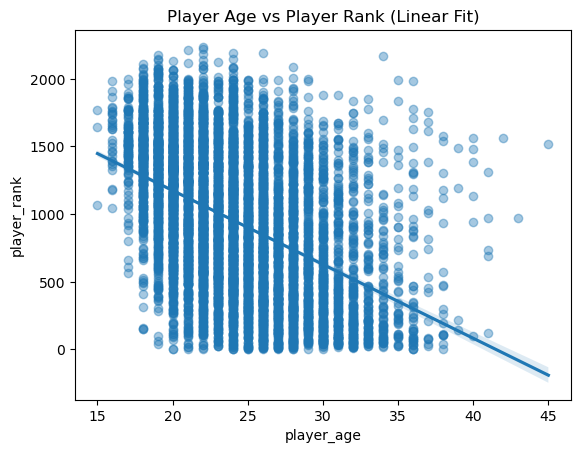

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.diagnostic import linear_reset

df_sorted = df_sorted[
    df_sorted['player_age'].replace([np.inf, -np.inf], np.nan).notna() &
    df_sorted['player_rank'].replace([np.inf, -np.inf], np.nan).notna()
]

# Scatterplot with regression line helps visually inspect 
# whether the relationship between age and rank is linear.
sns.regplot(
    data=df_sorted, 
    x='player_age', 
    y='player_rank', 
    scatter_kws={'alpha':0.4}  # transparency for readability
)
plt.title("Player Age vs Player Rank (Linear Fit)")
plt.show()


In [17]:
# Pearson → tests linear correlation
pearson_corr, pearson_p = stats.pearsonr(
    df_sorted['player_age'], 
    df_sorted['player_rank']
)

# Spearman → correlation of ranked values (monotonic relationship)
spearman_corr, spearman_p = stats.spearmanr(
    df_sorted['player_age'], 
    df_sorted['player_rank']
)

print("Pearson correlation:", pearson_corr, "p =", pearson_p)
print("Spearman correlation:", spearman_corr, "p =", spearman_p)

# Interpretation:
# - Correlation close to 0 → weak relationship
# - Negative correlation → better ranking at younger ages
# - p < 0.05 → the relationship is statistically significant


Pearson correlation: -0.4561885135732651 p = 0.0
Spearman correlation: -0.47659949045886957 p = 0.0


In [18]:
# Build a simple linear regression model: rank ~ age
X = sm.add_constant(df_sorted['player_age'])
y = df_sorted['player_rank']

model = sm.OLS(y, X).fit()

# RESET test checks if we are missing nonlinear terms
reset_test = linear_reset(model, use_f=True)
print(reset_test)

# Interpretation:
# - If p-value < 0.05 → Nonlinearity exists (linear model not appropriate)
# - If p-value > 0.05 → Linear model is acceptable


<F test: F=113.70767723870173, p=2.1588546810837685e-49, df_denom=7.68e+03, df_num=2>


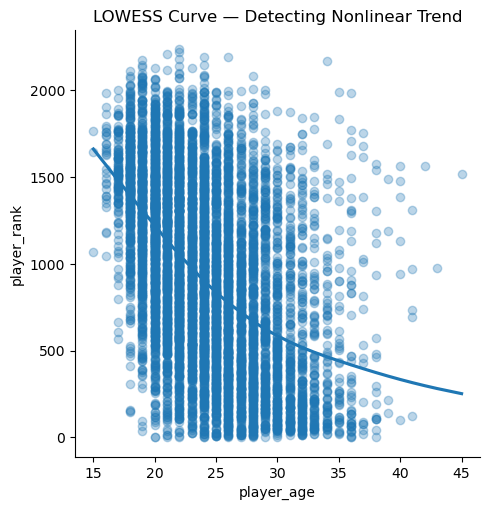

In [19]:
# LOWESS (Locally Weighted Regression) shows smooth nonlinear patterns
sns.lmplot(
    data=df_sorted, 
    x="player_age", 
    y="player_rank",
    lowess=True,
    scatter_kws={'alpha':0.3}
)
plt.title("LOWESS Curve — Detecting Nonlinear Trend")
plt.show()

# If the LOWESS curve bends strongly → nonlinear relationship.
